In [1]:
pip install transformers

In [2]:
from transformers import BertTokenizer,BertModel
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

#bert = BertModel.from_pretrained('dmis-lab/biobert-large-cased-v1.1')
#tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

bert = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embedding_dim = bert.config.to_dict()['hidden_size']

## YOU MAY CHANGE THESE HYPERPARAMETERS
LABEL_NUM = 5
BATCH_SIZE = 32 #16
LEARNING_RATE = 5e-5 #1e-5
DROPOUT_RATIO = 0.2
MAX_EPOCH = 5
TEST_TRAIN_RATIO = 0.3
MAX_LEN = 256


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
## if you want to use TPU on Colab, run this code

!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()

     |█████████                       | 41.2MB 47.1MB/s eta 0:00:03ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 313, in _get_abstract_dist_for
    req, self.session, self.finder, self.require_hashes
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/operations/prepare.py", line 194, in prepare_linked_

ModuleNotFoundError: ignored

In [4]:
text_data = pd.read_csv('train.dat', sep = '\t', header=None)
df_train, df_test = train_test_split(text_data, test_size=TEST_TRAIN_RATIO)
df_train.reset_index(drop=True, inplace = True)
df_test.reset_index(drop=True, inplace = True)

## Prepare Dataset for BERT

### TODO : Preprocess input data

#### example : when maximum length is 8

- original input sentence - "I really love you"
- tokenizing (use ``bert_tokenizer.tokenize``) -  ['i', 'really', 'love', 'you']
- Add special token - ['[CLS]' 'i', 'really', 'love', 'you', '[SEP]'] (length = 6)
- Add padding tokens to fit maximum length - ['[CLS]' 'i', 'really', 'love', 'you', '[SEP]', '[PAD]','[PAD]']
- Convert tokens to id (use ``bert_tokenizer.convert_tokens_to_ids``)
- make attention mask to tell which token is a padding token - [1,1,1,1,1,1,0,0]

You may choose other way (even simpler) to preprocess the input text. see https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer or https://huggingface.co/transformers/model_doc/bert.html#berttokenizer


In [5]:
class ClinicalDataset(Dataset):

    def __init__(self, dataframe, maxlen, tokenizer):

        self.df = dataframe.rename(columns={0: "label", 1: "text"})
        #Initialize the BERT tokenizer
        self.tokenizer = tokenizer
        
        self.df['label'] = self.df['label'].apply(lambda x : x-1)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        label = self.df.loc[index, 'label']

        ##TODO 
        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) 
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        sequence = torch.tensor(tokens_ids)

        attention_mask = (sequence != 0).long()

        return sequence, attention_mask, label

In [6]:
#Creating instances of training and validation set
train_set = ClinicalDataset(df_train, maxlen = MAX_LEN,tokenizer = bert_tokenizer)
val_set = ClinicalDataset(df_test, maxlen = MAX_LEN,tokenizer = bert_tokenizer)

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, num_workers = 2)
batch = next(iter(train_loader))
print(batch)

[tensor([[  101, 18834,  7277,  ...,     0,     0,     0],
        [  101,  8040,  3917,  ...,     0,     0,     0],
        [  101,  7490, 26721,  ...,  2001,  6560,   102],
        ...,
        [  101, 14978,  1012,  ...,     0,     0,     0],
        [  101,  3276,  1997,  ...,  2558,  1997,   102],
        [  101,  2026, 18349,  ...,  5001,  1010,   102]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([3, 3, 2, 4, 0, 4, 4, 1, 4, 0, 0, 2, 3, 4, 0, 4, 2, 0, 3, 1, 4, 4, 4, 1,
        4, 2, 3, 1, 4, 2, 4, 0])]


## Define Neural Network

### TODO : Define layers and data flow 

``nn.Dropout`` could be used to prevent overffiting. (parameter : dropout ratio)

from ``bert.config.to_dict()['hidden_size']``, we can obtain size of embedding vector used in pretrained BERT model.

Here is information about pytorch functions that used for layers (e.g. ``nn.Linear``):
https://pytorch.org/docs/stable/nn.html

Here is more information about BERT model implementation on PyTorch : https://huggingface.co/transformers/model_doc/bert.html#bertmodel




In [7]:
class Classifier(nn.Module):

    def __init__(self,bert,output_len,dropout):
        super(Classifier, self).__init__()
        ##TODO
        #print(bert.config.to_dict()['hidden_size']) 768
        ## Define Layers

        #Instantiating BERT model object
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        #Drop out
        self.pre_classifier = nn.Linear(768, 768)
        self.drop = nn.Dropout(dropout)

        #Classification layer
        self.cls_layer = nn.Linear(768, output_len)
        

    def forward(self, sequence, attention_masks):

        ##TODO
        ##Define data flow in neural network
        cont_reps = self.bert(sequence, attention_mask = attention_masks)
        cls_rep = cont_reps[0][:, 0]
        pre_cls = self.pre_classifier(cls_rep)
        drop_out = self.drop(pre_cls)
        logits = self.cls_layer(drop_out)
        
        return logits


In [8]:
criterion = nn.CrossEntropyLoss()

#device = torch.device('cpu')
net = Classifier(bert,LABEL_NUM,DROPOUT_RATIO)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)

## Train the model

In [9]:
def get_accuracy(output, labels):

    _, pred = torch.max(output.data, axis=1)
    ans = (pred == labels.squeeze()).sum()
    
    return ans

def evaluate(net, criterion, dataloader):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    ans = 0
    total_num = 0
    

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            output = net(seq, attn_masks)
            mean_loss += criterion(output.squeeze(-1), labels.long()).item()
            
            ans += get_accuracy(output, labels)
            total_num += labels.size(0)
            count += 1


    return float(ans) / float(total_num), mean_loss / count



In [10]:
def train(net, criterion, optimizer, dataloader):
    
    total_loss = 0
    count = 0
    ans = 0
    total_num = 0
    net.train()
        
    for i, (sequence, attention_mask, labels) in enumerate(dataloader):
        
        
        optimizer.zero_grad()  
        
        sequence, attention_mask, labels = sequence.to(device), attention_mask.to(device), labels.to(device)
        
        output = net(sequence, attention_mask)
        
        loss = criterion(output.squeeze(-1), labels.long())
        
        ##loss.backward() calculate gradients of each parameters
        loss.backward()
        
        ##optimizer.step() updates learnable parameters in the NN using calculated gradients
        optimizer.step()
        #xm.optimizer_step(optimizer, barrier=True)
        
        total_loss += criterion(output.squeeze(-1), labels.long()).item()
        ans += get_accuracy(output, labels)
        total_num += labels.size(0)
        count += 1
        acc = float(ans)/ float(total_num)
        mean_loss = float(total_loss/count)  

        if (i + 1) % 100 == 0:
            print("Iteration {} complete. Loss : {} Accuracy : {}".format(i+1, mean_loss, acc))
     
    return acc, mean_loss
    
  

In [11]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []
for epoch in range(MAX_EPOCH):
    train_acc, train_loss = train(net,criterion,optimizer,train_loader)
    test_acc, test_loss = evaluate(net,criterion,val_loader)
    print("Epoch {} complete! Validation Loss : {} Validation Accuracy : {}".format(epoch+1,test_loss,test_acc))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

Iteration 100 complete. Loss : 1.1809767013788224 Accuracy : 0.5084375
Iteration 200 complete. Loss : 1.0672844737768172 Accuracy : 0.5571875
Iteration 300 complete. Loss : 1.0237632677952448 Accuracy : 0.5758333333333333
Epoch 1 complete! Validation Loss : 0.9267019318307147 Validation Accuracy : 0.6048014773776547
Iteration 100 complete. Loss : 0.843471406698227 Accuracy : 0.6459375
Iteration 200 complete. Loss : 0.8145121014118195 Accuracy : 0.65765625
Iteration 300 complete. Loss : 0.8067869098981222 Accuracy : 0.6611458333333333
Epoch 2 complete! Validation Loss : 0.9139856954707819 Validation Accuracy : 0.6128808864265928
Iteration 100 complete. Loss : 0.7195934364199639 Accuracy : 0.6959375
Iteration 200 complete. Loss : 0.7037405353784562 Accuracy : 0.7040625
Iteration 300 complete. Loss : 0.7002060651779175 Accuracy : 0.7032291666666667
Epoch 3 complete! Validation Loss : 0.9987528192646363 Validation Accuracy : 0.5881809787626963
Iteration 100 complete. Loss : 0.6312987667322

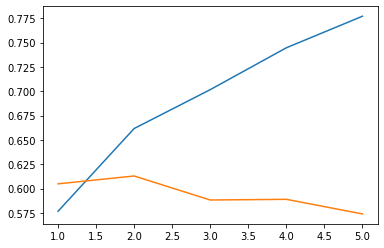

In [12]:
x = np.arange(1,MAX_EPOCH+1,1)

plt.plot(x,train_acc_list)
plt.plot(x,test_acc_list)